In [2]:
import numpy as np
import h5py
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) 
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


np.random.seed(1)      #指定随机种子

In [3]:
def zero_pad(X,pad):
    """
    把数据集X的图像边界全部使用0来扩充pad个宽度和高度。

    参数：
        X - 图像数据集，维度为（样本数，图像高度，图像宽度，图像通道数）
        pad - 整数，每个图像在垂直和水平维度上的填充量
    返回：
        X_paded - 扩充后的图像数据集，维度为（样本数，图像高度 + 2*pad，图像宽度 + 2*pad，图像通道数）

    """

    X_paded = np.pad(X,(
                        (0,0),       #样本数，不填充
                        (pad,pad),   #图像高度,你可以视为上面填充x个，下面填充y个(x,y)
                        (pad,pad),   #图像宽度,你可以视为左边填充x个，右边填充y个(x,y)
                        (0,0)),      #通道数，不填充
                        'constant', constant_values=0)      #连续一样的值填充

    return X_paded



x.shape = (4, 3, 3, 2)
x_paded.shape = (4, 7, 7, 2)
x[1, 1] = [[ 0.90085595 -0.68372786]
 [-0.12289023 -0.93576943]
 [-0.26788808  0.53035547]]
x_paded[1, 1] = [[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]


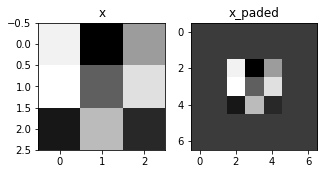

In [4]:
np.random.seed(1)
x = np.random.randn(4,3,3,2)
x_paded = zero_pad(x,2)
#查看信息
print ("x.shape =", x.shape)
print ("x_paded.shape =", x_paded.shape)
print ("x[1, 1] =", x[1, 1])
print ("x_paded[1, 1] =", x_paded[1, 1])

#绘制图
fig , axarr = plt.subplots(1,2)  #一行两列
axarr[0].set_title('x')
axarr[0].imshow(x[0,:,:,0])
axarr[1].set_title('x_paded')
axarr[1].imshow(x_paded[0,:,:,0])

In [5]:
def conv_single_step(a_slice_prev,W,b):
    """
    在前一层的激活输出的一个片段上应用一个由参数W定义的过滤器。
    这里切片大小和过滤器大小相同

    参数：
        a_slice_prev - 输入数据的一个片段，维度为（过滤器大小，过滤器大小，上一通道数）
        W - 权重参数，包含在了一个矩阵中，维度为（过滤器大小，过滤器大小，上一通道数）
        b - 偏置参数，包含在了一个矩阵中，维度为（1,1,1）

    返回：
        Z - 在输入数据的片X上卷积滑动窗口（w，b）的结果。
    """

    s = np.multiply(a_slice_prev,W) + b

    Z = np.sum(s)

    return Z

In [6]:
np.random.seed(1)

#这里切片大小和过滤器大小相同
a_slice_prev = np.random.randn(4,4,3)
W = np.random.randn(4,4,3)
b = np.random.randn(1,1,1)

Z = conv_single_step(a_slice_prev,W,b)

print("Z = " + str(Z))

Z = -23.16021220252078


In [7]:
def conv_forward(A_prev, W, b, hparameters):
    """
    实现卷积函数的前向传播

    参数：
        A_prev - 上一层的激活输出矩阵，维度为(m, n_H_prev, n_W_prev, n_C_prev)，（样本数量，上一层图像的高度，上一层图像的宽度，上一层过滤器数量）
        W - 权重矩阵，维度为(f, f, n_C_prev, n_C)，（过滤器大小，过滤器大小，上一层的过滤器数量，这一层的过滤器数量）
        b - 偏置矩阵，维度为(1, 1, 1, n_C)，（1,1,1,这一层的过滤器数量）
        hparameters - 包含了"stride"与 "pad"的超参数字典。

    返回：
        Z - 卷积输出，维度为(m, n_H, n_W, n_C)，（样本数，图像的高度，图像的宽度，过滤器数量）
        cache - 缓存了一些反向传播函数conv_backward()需要的一些数据
    """

    #获取来自上一层数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取权重矩阵的基本信息
    ( f , f ,n_C_prev , n_C ) = W.shape

    #获取超参数hparameters的值
    stride = hparameters["stride"]
    pad = hparameters["pad"]

    #计算卷积后的图像的宽度高度，参考上面的公式，使用int()来进行板除
    n_H = int(( n_H_prev - f + 2 * pad )/ stride) + 1
    n_W = int(( n_W_prev - f + 2 * pad )/ stride) + 1

    #使用0来初始化卷积输出Z
    Z = np.zeros((m,n_H,n_W,n_C))

    #通过A_prev创建填充过了的A_prev_pad
    A_prev_pad = zero_pad(A_prev,pad)

    for i in range(m):                              #遍历样本
        a_prev_pad = A_prev_pad[i]                  #选择第i个样本的扩充后的激活矩阵
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #切片位置定位好了我们就把它取出来,需要注意的是我们是“穿透”取出来的，
                    #自行脑补一下吸管插入一层层的橡皮泥就明白了
                    a_slice_prev = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]
                    #执行单步卷积
                    Z[i,h,w,c] = conv_single_step(a_slice_prev,W[: ,: ,: ,c],b[0,0,0,c])

    #数据处理完毕，验证数据格式是否正确
    assert(Z.shape == (m , n_H , n_W , n_C ))

    #存储一些缓存值，以便于反向传播使用
    cache = (A_prev,W,b,hparameters)

    return (Z , cache)

In [8]:
np.random.seed(1)

A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)

hparameters = {"pad" : 2, "stride": 1}

Z , cache_conv = conv_forward(A_prev,W,b,hparameters)

print("np.mean(Z) = ", np.mean(Z))
print("cache_conv[0][1][2][3] =", cache_conv[0][1][2][3])

np.mean(Z) =  0.15585932488906465
cache_conv[0][1][2][3] = [-0.20075807  0.18656139  0.41005165]


In [9]:
def pool_forward(A_prev,hparameters,mode="max"):
    """
    实现池化层的前向传播

    参数：
        A_prev - 输入数据，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        hparameters - 包含了 "f" 和 "stride"的超参数字典
        mode - 模式选择【"max" | "average"】

    返回：
        A - 池化层的输出，维度为 (m, n_H, n_W, n_C)
        cache - 存储了一些反向传播需要用到的值，包含了输入和超参数的字典。
    """

    #获取输入数据的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape

    #获取超参数的信息
    f = hparameters["f"]
    stride = hparameters["stride"]

    #计算输出维度
    n_H = int((n_H_prev - f) / stride ) + 1
    n_W = int((n_W_prev - f) / stride ) + 1
    n_C = n_C_prev

    #初始化输出矩阵
    A = np.zeros((m , n_H , n_W , n_C))

    for i in range(m):                              #遍历样本
        for h in range(n_H):                        #在输出的垂直轴上循环
            for w in range(n_W):                    #在输出的水平轴上循环
                for c in range(n_C):                #循环遍历输出的通道
                    #定位当前的切片位置
                    vert_start = h * stride         #竖向，开始的位置
                    vert_end = vert_start + f       #竖向，结束的位置
                    horiz_start = w * stride        #横向，开始的位置
                    horiz_end = horiz_start + f     #横向，结束的位置
                    #定位完毕，开始切割
                    a_slice_prev = A_prev[i,vert_start:vert_end,horiz_start:horiz_end,c]

                    #对切片进行池化操作
                    if mode == "max":
                        A[ i , h , w , c ] = np.max(a_slice_prev)
                    elif mode == "average":
                        A[ i , h , w , c ] = np.mean(a_slice_prev)

    #池化完毕，校验数据格式
    assert(A.shape == (m , n_H , n_W , n_C))

    #校验完毕，开始存储用于反向传播的值
    cache = (A_prev,hparameters)

    return A,cache

In [10]:
np.random.seed(1)
A_prev = np.random.randn(2,4,4,3)
hparameters = {"f":4 , "stride":1}

A , cache = pool_forward(A_prev,hparameters,mode="max")
A, cache = pool_forward(A_prev, hparameters)
print("mode = max")
print("A =", A)
print("----------------------------")
A, cache = pool_forward(A_prev, hparameters, mode = "average")
print("mode = average")
print("A =", A)

mode = max
A = [[[[1.74481176 1.6924546  2.10025514]]]


 [[[1.19891788 1.51981682 2.18557541]]]]
----------------------------
mode = average
A = [[[[-0.09498456  0.11180064 -0.14263511]]]


 [[[-0.09525108  0.28325018  0.33035185]]]]


In [11]:
def conv_backward(dZ,cache):
    """
    实现卷积层的反向传播

    参数：
        dZ - 卷积层的输出Z的 梯度，维度为(m, n_H, n_W, n_C)
        cache - 反向传播所需要的参数，conv_forward()的输出之一

    返回：
        dA_prev - 卷积层的输入（A_prev）的梯度值，维度为(m, n_H_prev, n_W_prev, n_C_prev)
        dW - 卷积层的权值的梯度，维度为(f,f,n_C_prev,n_C)
        db - 卷积层的偏置的梯度，维度为（1,1,1,n_C）

    """
    #获取cache的值
    (A_prev, W, b, hparameters) = cache

    #获取A_prev的基本信息
    (m, n_H_prev, n_W_prev, n_C_prev) = A_prev.shape

    #获取dZ的基本信息
    (m,n_H,n_W,n_C) = dZ.shape

    #获取权值的基本信息
    (f, f, n_C_prev, n_C) = W.shape

    #获取hparaeters的值
    pad = hparameters["pad"]
    stride = hparameters["stride"]

    #初始化各个梯度的结构
    dA_prev = np.zeros((m,n_H_prev,n_W_prev,n_C_prev))
    dW = np.zeros((f,f,n_C_prev,n_C))
    db = np.zeros((1,1,1,n_C))

    #前向传播中我们使用了pad，反向传播也需要使用，这是为了保证数据结构一致
    A_prev_pad = zero_pad(A_prev,pad)
    dA_prev_pad = zero_pad(dA_prev,pad)

    #现在处理数据
    for i in range(m):
        #选择第i个扩充了的数据的样本,降了一维。
        a_prev_pad = A_prev_pad[i]
        da_prev_pad = dA_prev_pad[i]

        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #定位完毕，开始切片
                    a_slice = a_prev_pad[vert_start:vert_end,horiz_start:horiz_end,:]

                    #切片完毕，使用上面的公式计算梯度
                    da_prev_pad[vert_start:vert_end, horiz_start:horiz_end,:] += W[:,:,:,c] * dZ[i, h, w, c]
                    dW[:,:,:,c] += a_slice * dZ[i,h,w,c]
                    db[:,:,:,c] += dZ[i,h,w,c]
        #设置第i个样本最终的dA_prev,即把非填充的数据取出来。
        dA_prev[i,:,:,:] = da_prev_pad[pad:-pad, pad:-pad, :]

    #数据处理完毕，验证数据格式是否正确
    assert(dA_prev.shape == (m, n_H_prev, n_W_prev, n_C_prev))

    return (dA_prev,dW,db)



In [12]:
np.random.seed(1)
#初始化参数
A_prev = np.random.randn(10,4,4,3)
W = np.random.randn(2,2,3,8)
b = np.random.randn(1,1,1,8)
hparameters = {"pad" : 2, "stride": 1}

#前向传播
Z , cache_conv = conv_forward(A_prev,W,b,hparameters)
#反向传播
dA , dW , db = conv_backward(Z,cache_conv)
print("dA_mean =", np.mean(dA))
print("dW_mean =", np.mean(dW))
print("db_mean =", np.mean(db))

dA_mean = 9.608990675868995
dW_mean = 10.581741275547566
db_mean = 76.37106919563735


In [13]:
def create_mask_from_window(x):
    """
    从输入矩阵中创建掩码，以保存最大值的矩阵的位置。

    参数：
        x - 一个维度为(f,f)的矩阵

    返回：
        mask - 包含x的最大值的位置的矩阵
    """
    mask = x == np.max(x)

    return mask

In [14]:
np.random.seed(1)

x = np.random.randn(2,3)

mask = create_mask_from_window(x)

print("x = " + str(x)) 
print("mask = " + str(mask))

x = [[ 1.62434536 -0.61175641 -0.52817175]
 [-1.07296862  0.86540763 -2.3015387 ]]
mask = [[ True False False]
 [False False False]]


In [15]:
def distribute_value(dz,shape):
    """
    给定一个值，为按矩阵大小平均分配到每一个矩阵位置中。

    参数：
        dz - 输入的实数
        shape - 元组，两个值，分别为n_H , n_W

    返回：
        a - 已经分配好了值的矩阵，里面的值全部一样。

    """
    #获取矩阵的大小
    (n_H , n_W) = shape

    #计算平均值
    average = dz / (n_H * n_W)

    #填充入矩阵
    a = np.ones(shape) * average

    return a

In [16]:
dz = 2
shape = (2,2)

a = distribute_value(dz,shape)
print("a = " + str(a))

a = [[0.5 0.5]
 [0.5 0.5]]


In [17]:
def pool_backward(dA,cache,mode = "max"):
    """
    实现池化层的反向传播

    参数:
        dA - 池化层的输出的梯度，和池化层的输出的维度一样
        cache - 池化层前向传播时所存储的参数。
        mode - 模式选择，【"max" | "average"】

    返回：
        dA_prev - 池化层的输入的梯度，和A_prev的维度相同

    """
    #获取cache中的值
    (A_prev , hparaeters) = cache

    #获取hparaeters的值
    f = hparaeters["f"]
    stride = hparaeters["stride"]

    #获取A_prev和dA的基本信息
    (m , n_H_prev , n_W_prev , n_C_prev) = A_prev.shape
    (m , n_H , n_W , n_C) = dA.shape

    #初始化输出的结构
    dA_prev = np.zeros_like(A_prev)

    #开始处理数据
    for i in range(m):
        a_prev = A_prev[i]      
        for h in range(n_H):
            for w in range(n_W):
                for c in range(n_C):
                    #定位切片位置
                    vert_start = h
                    vert_end = vert_start + f
                    horiz_start = w
                    horiz_end = horiz_start + f

                    #选择反向传播的计算方式
                    if mode == "max":
                        #开始切片
                        a_prev_slice = a_prev[vert_start:vert_end,horiz_start:horiz_end,c]
                        #创建掩码
                        mask = create_mask_from_window(a_prev_slice)
                        #计算dA_prev
                        dA_prev[i,vert_start:vert_end,horiz_start:horiz_end,c] += np.multiply(mask,dA[i,h,w,c])

                    elif mode == "average":
                        #获取dA的值
                        da = dA[i,h,w,c]
                        #定义过滤器大小
                        shape = (f,f)
                        #平均分配
                        dA_prev[i,vert_start:vert_end, horiz_start:horiz_end ,c] += distribute_value(da,shape)
    #数据处理完毕，开始验证格式
    assert(dA_prev.shape == A_prev.shape)

    return dA_prev

In [19]:
np.random.seed(1)
A_prev = np.random.randn(5, 5, 3, 2)
hparameters = {"stride" : 1, "f": 2}
A, cache = pool_forward(A_prev, hparameters)
dA = np.random.randn(5, 4, 2, 2)

dA_prev = pool_backward(dA, cache, mode = "max")
print("mode = max")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1])  
print()
dA_prev = pool_backward(dA, cache, mode = "average")
print("mode = average")
print('mean of dA = ', np.mean(dA))
print('dA_prev[1,1] = ', dA_prev[1,1]) 

mode = max
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.          0.        ]
 [ 5.05844394 -1.68282702]
 [ 0.          0.        ]]

mode = average
mean of dA =  0.14571390272918056
dA_prev[1,1] =  [[ 0.08485462  0.2787552 ]
 [ 1.26461098 -0.25749373]
 [ 1.17975636 -0.53624893]]


In [20]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.python.framework import ops

import cnn_utils

%matplotlib inline
np.random.seed(1)

In [21]:
index = 6
plt.imshow(X_train_orig[index])
print ("y = " + str(np.squeeze(Y_train_orig[:, index])))

NameError: name 'X_train_orig' is not defined